In [86]:
#def process_gcn(payload, root):
#    if root.attrib['role'] != 'observation':
#        return

    # Read all of the VOEvent parameters from the "What" section.
#    params = {elem.attrib['name']:
#              elem.attrib['value']
#              for elem in root.iterfind('.//Param')}

#put into script to allow autorun

In [87]:
from astropy.io import fits
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value, FlatLambdaCDM
import urllib
import healpy as hp
#import gcn

In [88]:
import time
start_time = time.time()
url='http://skyserver.sdss.org/dr15/en/tools/search/x_results.aspx?searchtool=SQL&'

In [89]:
prob, distmu, distsigma, distnorm = hp.read_map('bayestar.fits.gz', field = [0,1,2,3])
hpy = hp.read_map('../bayestar.fits.gz')

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


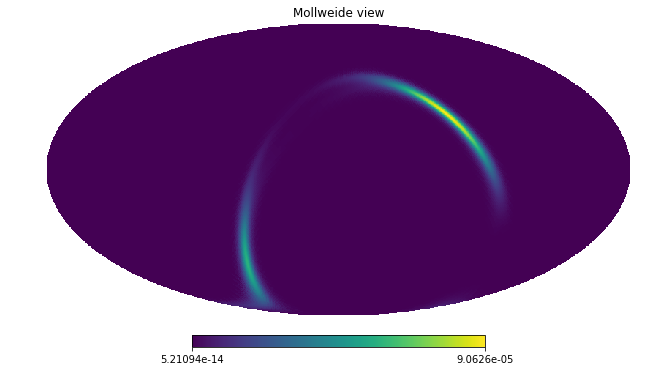

In [90]:
hp.mollview(prob, rot=180)

In [91]:
prob1 = list(prob)
npix = len(prob)
nside = hp.npix2nside(npix)

In [92]:
ipix = prob1.index(np.amax(prob1))
theta, phi = hp.pix2ang(nside, ipix)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)
ra, dec

(107.75390625, 27.953186883381132)

In [93]:
r = np.linspace(0,7000,num=1000)

In [94]:
def distance(rr, pixel):
    return distnorm[pixel]/(np.sqrt(2*np.pi)*distsigma[pixel])*np.exp(-(rr-distmu[pixel])**2 
                                                               /(2*distsigma[pixel])**2)*rr**2

Find the most probable distance of each pixel and the ra and dec for that pixel

In [95]:
most_probable_distance = []
ra, dec, std = [], [], []
probability = []

for pix1 in range(int(len(prob1))):
    dist = distance(r,pix1)
    dist = list(dist)
    inde = dist.index(np.amax(dist))
    most_probable_distance.append(inde * 7) #in units of Mpc
    theta, phi = hp.pix2ang(nside, pix1)
    ra.append(np.rad2deg(phi))
    dec.append(np.rad2deg(0.5 * np.pi - theta))
    probability.append(prob1[pix1])

Append all data needed for an sql to a list and sort it so highest probability is at the top

In [96]:
# data1 is the same as data with duplicates removed
data,data1, z, stdz  = [], [], [], []
for i in range(int(len(probability))):
    if dec[i] > -10:
        data.append([probability[i] ,most_probable_distance[i],int(ra[i]), int(dec[i]), distsigma[i]])
    
data = sorted(data, key=lambda data: data[0]) #sort all data by the probability of the object
# being found in the ra and dec defined by that pixel

for i in range(int(len(data))):
    if data[i][3]!=data[i-1][3] and data[i][2]!=data[i-1][2]:
        data1.append([probability[i] ,most_probable_distance[i],int(ra[i]), int(dec[i]), distsigma[i]])


#for i in range(len(data1)):
for i in range(200):
    if data1[i][1] > 0.001:
        z.append(z_at_value(Planck13.luminosity_distance,data1[i][1]*u.Mpc)) #calculate the redshift
        stdz.append(z_at_value(Planck13.luminosity_distance,data1[i][4]*u.Mpc ) )

#print("--- %s seconds ---" % (time.time() - start_time))

Excludes data that is unobservable to us

In [215]:

data_for_telescope = []
for i in range(len(z)):
    sql = 'SELECT objid,ra,dec, class, z as redshift FROM SpecPhoto WHERE z >' + str(z[i] - 5* stdz[i]) + ' AND z < ' + str(z[i] + 5* stdz[i]) + ' AND class = "GALAXY" AND ra > ' + str(data[i][2] - 1) + ' AND ra < ' + str(data[i][2] + 1) + ' AND dec > '+ str(data[i][3] - 1) + ' AND dec <' + str(data[i][3] + 1)
    #performs sql for most probable sky locations
    params = urllib.parse.urlencode({'cmd': sql, 'format': 'fits'}) #open the connection and run the sql
    urllib.request.urlretrieve(url+params, 'gt1.fits'); #collect and save the data
    hud = fits.open('gt1.fits') # read the file the data was output to
    if len(hud) == 1:
        continue
    else:
        galaxies = (np.array(hud[1].data))
        for j in range(len(galaxies)):
            theta = 0.5 * np.pi - np.deg2rad(galaxies[j][2])
            phi = np.deg2rad(galaxies[j][1])
            pix = hp.ang2pix(nside, theta, phi)
            d = Planck13.luminosity_distance(galaxies[j][4])
            prob_of_gal = distance((d.value), pix)
            data_for_telescope.append([galaxies[j][0], galaxies[j][1], galaxies[j][2], galaxies[j][4]
                                       , d.value, prob_of_gal])


print("--- %s seconds ---" % (time.time() - start_time))

--- 186736.89444446564 seconds ---


In [216]:
data_for_telescope = sorted(data_for_telescope, key=lambda l: sum(l))
data_tele = []
ID = []
for i in range(len(data_for_telescope)):
    ID.append(data_for_telescope[i][0])
for i in range(len(data_for_telescope)):
    if ID[i] not in ID[0:i-1] and ID[i] not in ID[i+1:len(ID)-1]:
        data_tele.append(data_for_telescope[i])
data_tele = sorted(data_tele, key=lambda data_tele: data_tele[5], reverse=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 186867.15905594826 seconds ---


In [209]:
data_for_telescope[4:6][0]

[1237651250439520509,
 241.07318056346472,
 49.462860806325374,
 0.08302419,
 390.0044716322235,
 0.0]

## Need to do: 
#####    1) Data visible during current date
#####    3) above below 20 in l for galacticc from astropy switch

In [149]:
len(z)

200

In [217]:
len(data_tele)

423

In [218]:
for i in range(20):
    print(data_tele[i][0], ID[i])

1237662700791791925 1237651250439520542
1237651716407951529 1237651250439520563
1237665569830076651 1237651250439520542
1237662702402076873 1237651250439520563
1237665570367013146 1237651250439520509
1237651716408082703 1237651250439520509
1237665569830207839 1237651250439520938
1237665569293467984 1237651250439520938
1237665569293402314 1237651250439585998
1237665569830076633 1237651250439585998
1237665569293468034 1237651250439586091
1237665569293467692 1237651250439586091
1237665569293533497 1237651250439716915
1237665570903621909 1237651250439717123
1237662700791988440 1237651250439716915
1237662702401880287 1237651250439717123
1237662701865402564 1237651250439717030
1237662701865272376 1237651250439717064
1237662701865205986 1237651250439717040
1237662702401945930 1237651250439717030


In [85]:
sql

'SELECT p.objid,p.ra,p.dec, s.class, s.z as redshift FROM PhotoObj AS p JOIN SpecObj AS s ON s.bestobjid = p.objid WHERE s.z >-0.5984888349201369 AND s.z < 0.8289448805409505 AND s.class = "GALAXY" AND p.ra > 87 AND p.ra < 89 AND p.dec > 55 AND p.dec <57'

In [108]:
np.savetxt('Data_test_run', data_tele, delimiter=' ', header='ID RA Dec Redshift Distance(MPC) Probability')